# Training Overview
* 10 Minutes to Dask
* Why Dask?
* Dask APIs

# 10 minutes to Dask

* Use the Dask Dataframe API
* View the task graph
* View the distributed dashboard

In [1]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:51084 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


* Using the `distributed` scheduler
* We'll discuss later scheduler options later
* Creating a `Client` starts one on your local machine

In [2]:
import pandas as pd
import dask.dataframe as dd

Manually set the types here to minimize memory usage

In [3]:
pay_dtypes = {
    'fiscal_year': 'Int16',
    'payroll_number': None,
    'agency_name': 'category',
    'last_name': None,
    'first_name': None,
    'mid_init': None,
    'agency_start_date': object,
    'work_location_borough': 'category',
    'title_description': 'category',
    'leave_status_as_of_june_30': 'category',
    'base_salary': 'float64',
    'pay_basis': 'category',
    'regular_hours': 'float64',
    'regular_gross_paid': 'float64',
    'ot_hours': 'float64',
    'total_ot_paid': 'float64',
    'total_other_pay': 'float64',
    }

date_cols = ['agency_start_date']

all_cols = list(k for k,v in pay_dtypes.items() if v is not None)

In [4]:
pay = dd.read_csv(
    'nyc_payroll.csv', 
    dtype=pay_dtypes,
    usecols=all_cols,
    blocksize=200_000_000 # so we have 3 partitions
)

To see all the arguments to dd.read_csv, use documentation for `pd.read_csv`

In [5]:
# ?pd.read_csv

In [6]:
# dat = pd.read_csv('nyc_payroll.csv', low_memory=False)
# cols = [x.lower().replace(' ', '_') for x in list(dat.columns)]
# dat.columns = cols
# dat.to_csv('nyc_payroll.csv', index=False)

In [7]:
pay.dtypes

fiscal_year                      Int16
agency_name                   category
agency_start_date               object
work_location_borough         category
title_description             category
leave_status_as_of_june_30    category
base_salary                    float64
pay_basis                     category
regular_hours                  float64
regular_gross_paid             float64
ot_hours                       float64
total_ot_paid                  float64
total_other_pay                float64
dtype: object

In [8]:
pay.head()

,fiscal_year,agency_name,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay
0,2016,DISTRICT ATTORNEY-MANHATTAN,07/14/2003,MANHATTAN,COMMUNITY ASSOCIATE,ACTIVE,47678.0,per Annum,1830.00,47166.03,2.25,57.28,0.0
1,2016,DISTRICT ATTORNEY-MANHATTAN,06/12/1995,MANHATTAN,ADMINISTRATIVE ACCOUNTANT,ACTIVE,119959.0,per Annum,1831.00,119042.50,0.00,0.00,0.0
2,2016,DISTRICT ATTORNEY-MANHATTAN,10/11/2011,MANHATTAN,COMMUNITY ASSOCIATE,ON LEAVE,39966.0,per Annum,1181.68,27452.62,1.00,21.34,33.0
3,2016,DISTRICT ATTORNEY-MANHATTAN,12/01/2014,MANHATTAN,COMPUTER SYSTEMS MANAGER,ACTIVE,116000.0,per Annum,1831.00,115104.57,0.00,0.00,0.0
4,2016,DISTRICT ATTORNEY-MANHATTAN,05/21/2015,MANHATTAN,COLLEGE AIDE,CEASED,1.0,per Hour,0.00,3500.00,0.00,0.00,0.0


Dask operates on a task graph that has not yet been executed

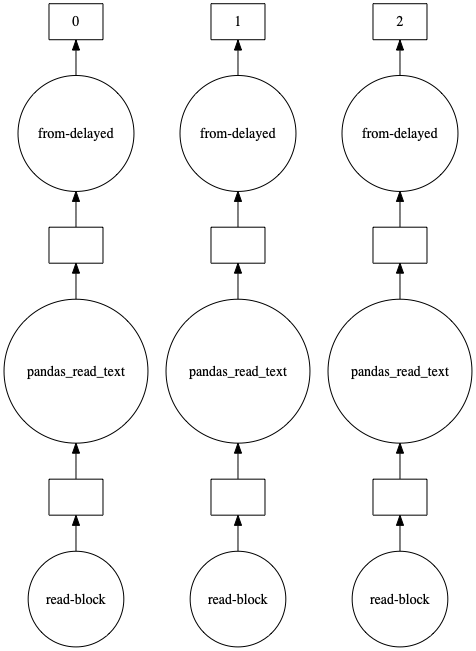

In [9]:
pay.visualize()

In [10]:
pay.npartitions

3

Number of partitions is based on the number of blocks

In [11]:
# Use more partitions at home
dd.read_csv(
    'nyc_payroll.csv', 
    dtype=pay_dtypes,
    usecols=all_cols,
    blocksize=100_000
).npartitions

4719

In [12]:
%time pay['base_salary'].max().compute()

CPU times: user 131 ms, sys: 16 ms, total: 147 ms
Wall time: 4.08 s


352763.0

## Dask operates out-of-memory by default
* Once we've run, data not persisted
* Need to reread the data from disk

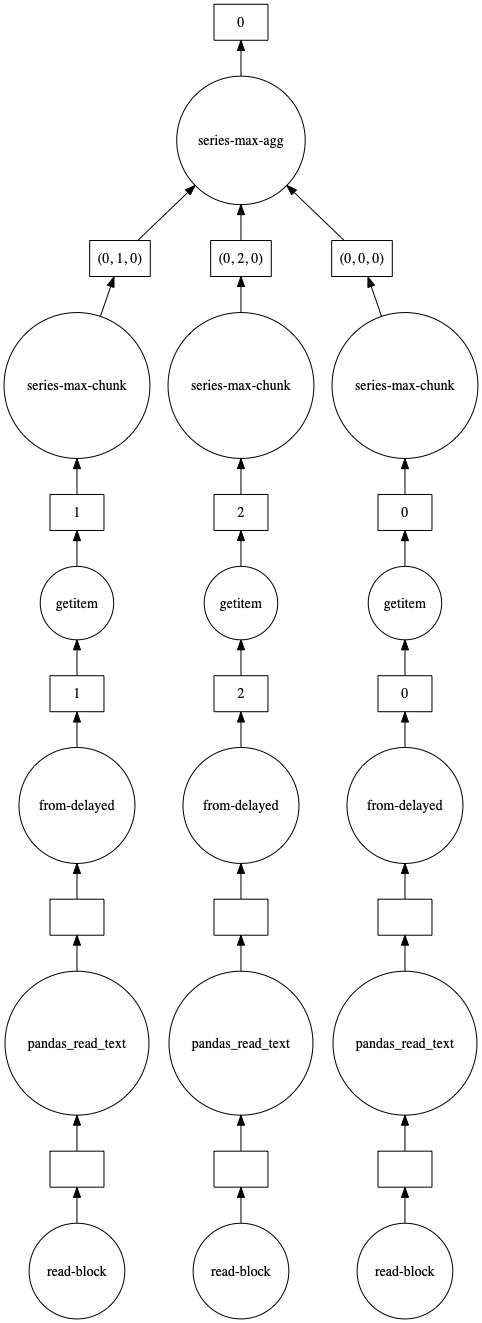

In [13]:
pay['base_salary'].max().visualize()

In [14]:
# setting the index will cause compute unless
# we know the divisions and the data is already sorted
pay = pay.persist()

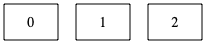

In [15]:
pay.visualize()

In [16]:
%time pay['base_salary'].max().compute()

CPU times: user 112 ms, sys: 16.2 ms, total: 128 ms
Wall time: 3.68 s


352763.0

## Compare to using base `pandas`

In [17]:
%%time

pay_pd = pd.read_csv(
    'nyc_payroll.csv', 
    dtype=pay_dtypes,
    usecols=all_cols,
)
pay_pd['base_salary'].max()

CPU times: user 7.78 s, sys: 472 ms, total: 8.25 s
Wall time: 8.2 s


352763.0

Once data is in memory, distributed solution is slower

In [18]:
%time pay_pd['base_salary'].max()

CPU times: user 13.2 ms, sys: 2.43 ms, total: 15.6 ms
Wall time: 12 ms


352763.0

In [19]:
client

Client Scheduler: tcp://127.0.0.1:51084 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


## Dask Distributed Dashboard

In [20]:
grp = pay.groupby('work_location_borough')

In [22]:
grp['base_salary'].agg(['mean', 'size']).compute()

,mean,size
work_location_borough,,
BRONX,47171.360681,149190
BROOKLYN,50890.928742,270114
MANHATTAN,37865.767834,1973648
OTHER,108812.605680,71698
QUEENS,50289.966593,314273
RICHMOND,52540.433670,38231
ALBANY,66348.303243,74
DELAWARE,57115.424514,463
NASSAU,29473.577551,196


distributed.utils - ERROR - 'aggregate-agg-getitem'
Traceback (most recent call last):
  File "/Users/daniel/miniconda3/envs/pydask/lib/python3.7/site-packages/distributed/utils.py", line 664, in log_errors
    yield
  File "/Users/daniel/miniconda3/envs/pydask/lib/python3.7/site-packages/distributed/dashboard/components/shared.py", line 312, in update
    ts = metadata["keys"][self.key]
KeyError: 'aggregate-agg-getitem'
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x115986b50>>, <Task finished coro=<_needs_document_lock.<locals>._needs_document_lock_wrapper() done, defined at /Users/daniel/miniconda3/envs/pydask/lib/python3.7/site-packages/bokeh/server/session.py:51> exception=KeyError('aggregate-agg-getitem')>)
Traceback (most recent call last):
  File "/Users/daniel/miniconda3/envs/pydask/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret 

# Why Dask?

### Python all the way down...

* Framework for parallel/distributed computing written in pure Python
* If you're already using Python, just add another package
* Integrates with existing Python environment, e.g. `numpy`, `pandas`, `sklearn`

### From laptop to cluster

* One line to start using on your laptop
* Scripts to deploy to HPC, YARN, Kubernetes, a bunch of instances over SSH...

## When to use dask

__Your problem:__

* does not fit in memory (on a single machine)
* may be sped up though parallelism (single or multi-machine)
* custom computations that don't fit into map/filter/reduce framework

## When to not use Dask

“Parallelism and distributed computing are expensive ways to accelerate your application.”

Dask Documentation

* Does your data fit into RAM?
* Can you use profile and rewrite the slow parts in a compiled language? (or use `numba`)

# Dask APIs

“We will encourage you to develop the three great virtues of a programmer: 
laziness, impatience, and hubris.”

Larry Wall - _Programming Perl_

### High Level

* DataFrame (pandas)
* Array numpy
* Bag (like pytoolz)

### Lower Level

* Delayed (Sync)
* Futures (Async)